In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

As well as the decoder model:

In [3]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 29s 2us/step


We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 5s 9ms/step - loss: 0.2767 - val_loss: 0.1914
Epoch 2/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1714 - val_loss: 0.1533
Epoch 3/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1436 - val_loss: 0.1331
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1281 - val_loss: 0.1210
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1179 - val_loss: 0.1126
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1109 - val_loss: 0.1067
Epoch 7/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1059 - val_loss: 0.1024
Epoch 8/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1021 - val_loss: 0.0992
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0994 - val_loss: 0.0969
Epoch 10/50
235/235 [==============================] - 3s 11ms/step - loss: 0.0975 - val_loss: 0.09

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [8]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 2ms/step


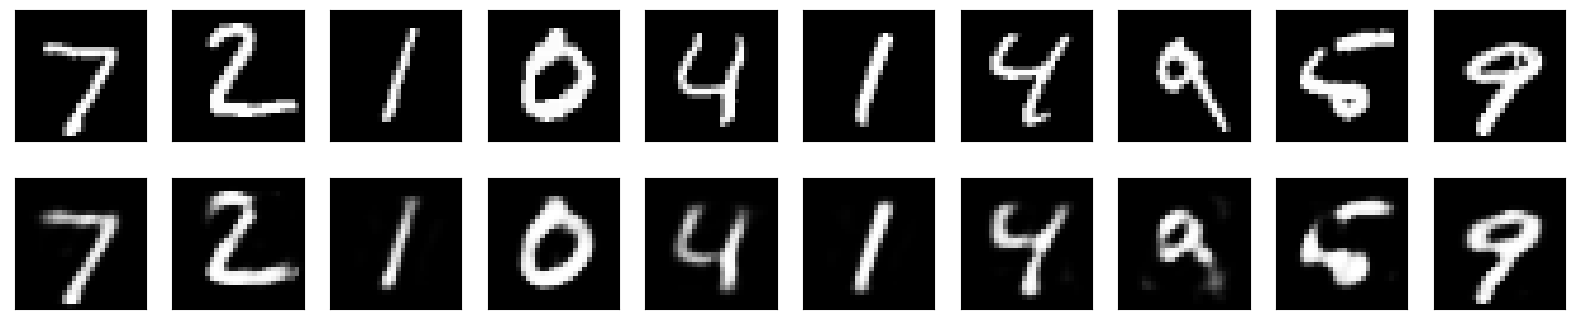

In [9]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

